## Analysis of feature selection results; single-cancer holdouts

TODO: document

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# analysis of results generated by script:
# 07_purity_prediction/run_purity_prediction.py
# (with varying feature_selection parameters)

single_cancer_dir = os.path.join('results', 'purity_binary_median', 'single_cancer')
pancancer_dir = os.path.join('results', 'purity_binary_median', 'pancancer')
pancancer_only_dir = os.path.join('results', 'purity_binary_median', 'all_other_cancers')

output_plots = False
output_plots_dir = None

large_n_dims = 1000
small_n_dims = 250

# metric to plot results for
metric = 'aupr'
delta_metric = 'delta_{}'.format(metric)

### Load results

We load the results of the single cancer, pan-cancer, and "pan-cancer only" (aka "all other cancers") experiments here.

In [3]:
single_cancer_df = au.load_purity_results_fs(
    single_cancer_dir, cfg.fs_methods, classify=True
)
single_cancer_df['train_set'] = 'single_cancer'

single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

single_cancer_df.drop(columns='gene', inplace=True)

# just use seed 42 for now, TODO change this
single_cancer_df = single_cancer_df[single_cancer_df.seed == 42].copy()

print(np.unique(single_cancer_df.seed))
print(single_cancer_df.shape)
single_cancer_df.head()

[42]
(3960, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.77846,0.84714,THYM,shuffled,42,train,0,random,250,single_cancer
1,0.43750,0.42239,THYM,shuffled,42,test,0,random,250,single_cancer
2,0.54810,0.61004,THYM,shuffled,42,cv,0,random,250,single_cancer
3,0.77642,0.75666,THYM,shuffled,42,train,1,random,250,single_cancer
4,0.55758,0.65136,THYM,shuffled,42,test,1,random,250,single_cancer


In [4]:
pancancer_df = au.load_purity_results_fs(
    pancancer_dir, cfg.fs_methods, classify=True
)
pancancer_df['train_set'] = 'pancancer'

pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

pancancer_df.drop(columns='gene', inplace=True)

# just use seed 42 for now, TODO change this
pancancer_df = pancancer_df[pancancer_df.seed == 42].copy()

print(np.unique(pancancer_df.seed))
print(pancancer_df.shape)
pancancer_df.head()

[42]
(3960, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.53917,0.52178,THYM,shuffled,42,train,0,random,250,pancancer
1,0.56875,0.56920,THYM,shuffled,42,test,0,random,250,pancancer
2,0.50519,0.49397,THYM,shuffled,42,cv,0,random,250,pancancer
3,0.53826,0.51742,THYM,shuffled,42,train,1,random,250,pancancer
4,0.50909,0.57533,THYM,shuffled,42,test,1,random,250,pancancer


In [5]:
pancancer_only_df = au.load_purity_results_fs(
    pancancer_only_dir, cfg.fs_methods, classify=True
)
pancancer_only_df['train_set'] = 'pancancer_only'

pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

pancancer_only_df.drop(columns='gene', inplace=True)

# just use seed 42 for now, TODO change this
pancancer_only_df = pancancer_only_df[pancancer_only_df.seed == 42].copy()

print(np.unique(pancancer_only_df.seed))
print(pancancer_only_df.shape)
pancancer_only_df.head()

[42]
(3960, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.54656,0.52727,THYM,shuffled,42,train,0,random,250,pancancer_only
1,0.59375,0.52558,THYM,shuffled,42,test,0,random,250,pancancer_only
2,0.51622,0.50629,THYM,shuffled,42,cv,0,random,250,pancancer_only
3,0.54656,0.52727,THYM,shuffled,42,train,1,random,250,pancancer_only
4,0.50303,0.59596,THYM,shuffled,42,test,1,random,250,pancancer_only


In [6]:
# get difference between true and shuffled models, split by
# feature selection method and holdout cancer type
def compare_from_experiment(experiment_df):
    compare_df = []
    for fs_method in experiment_df.fs_method.unique():
        compare_df.append(
            au.compare_control_ind(
                experiment_df[experiment_df.fs_method == fs_method], 
                identifier='holdout_cancer_type', metric=metric, verbose=True)
              .assign(fs_method=fs_method)
        )
    return pd.concat(compare_df)
    
single_cancer_compare_df = compare_from_experiment(single_cancer_df)
pancancer_compare_df = compare_from_experiment(pancancer_df)
pancancer_only_compare_df = compare_from_experiment(pancancer_only_df)

print(single_cancer_compare_df.shape,
      pancancer_compare_df.shape,
      pancancer_only_compare_df.shape)

(660, 5) (660, 5) (660, 5)


In [7]:
single_cancer_compare_df.head()

,identifier,seed,fold,delta_aupr,fs_method
0,ACC,42,0,0.20498,random
1,ACC,42,1,0.24690,random
2,ACC,42,2,0.31098,random
3,ACC,42,3,-0.16752,random
4,BLCA,42,0,0.33567,random


### Plot average performance across cancer types

In [8]:
print(single_cancer_compare_df.identifier.unique())

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD'
 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC'
 'UCS' 'UVM']


In [9]:
print(single_cancer_compare_df.fs_method.unique())

['random' 'pancan_f_test' 'mad_250' 'mad_1000' 'median_f_test']


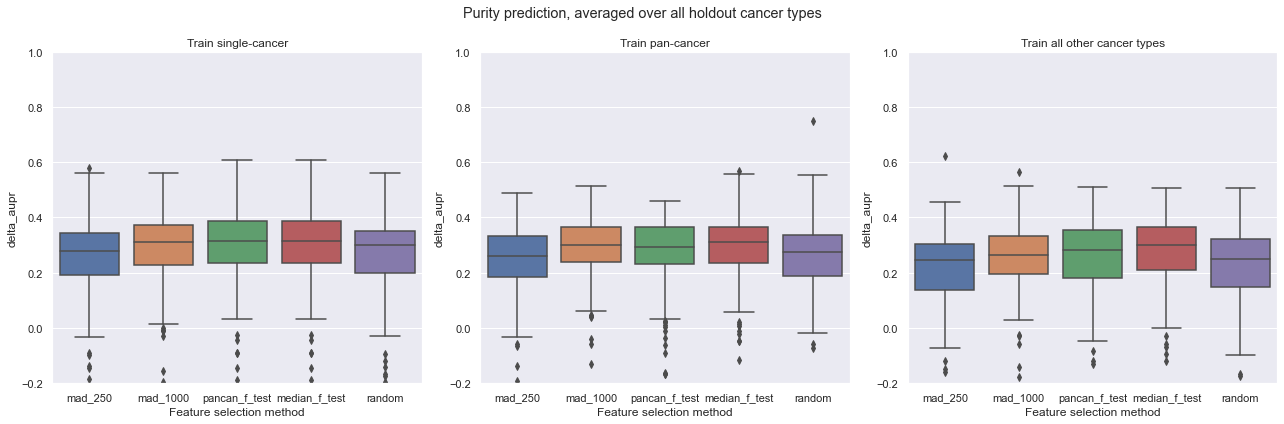

In [10]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

fs_method_order = [
    'mad_250',
    'mad_1000',
    'pancan_f_test',
    'median_f_test',
    'random'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over cancer types
    sns.boxplot(data=compare_df, x='fs_method', y=delta_metric,
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, averaged over all holdout cancer types')
plt.tight_layout()

# if output_plots:
#     output_plots_dir.mkdir(exist_ok=True)
#     plt.savefig(output_plots_dir / '{}_all_holdout.png'.format(gene),
#                 dpi=200, bbox_inches='tight')

In [11]:
# these are "non-carcinoma" cancer types in TCGA
# we anticipate that these will be the hardest to transfer models to (since
# most of TCGA, and thus most of our training set, is generally carcinomas),
# so it's also valuable to look at results filtered only to these
non_carcinomas = [
    'DLBC',
    'GBM',
    'LAML',
    'LGG',
    'SARC',
    'SKCM',
    'TGCT'
]

['DLBC' 'GBM' 'LAML' 'LGG' 'SARC' 'SKCM' 'TGCT']


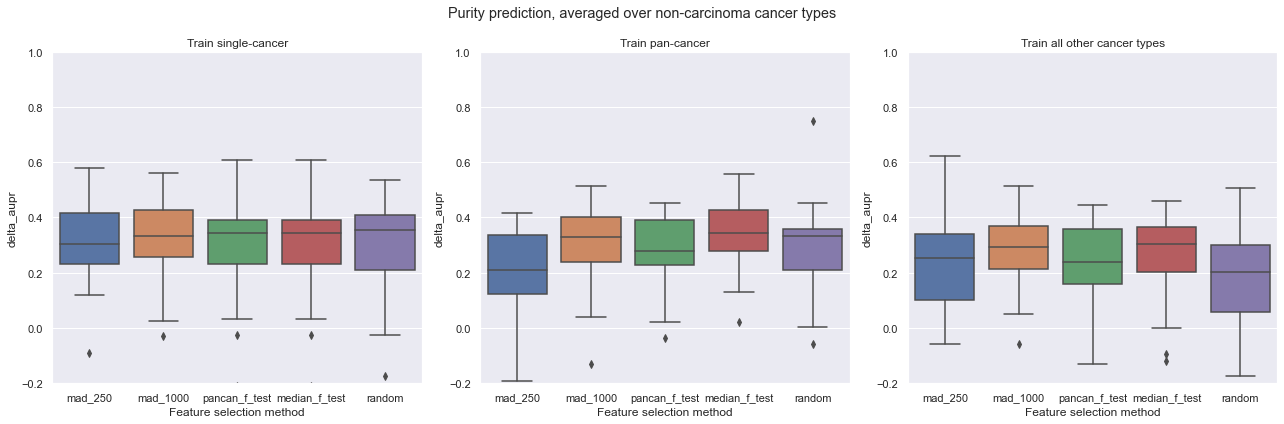

In [12]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over non-carcinoma cancer types
    plot_df = compare_df[(compare_df.identifier.isin(non_carcinomas))]
    if ix == 0:
        # look at which cancer types are actually present in dataset
        print(plot_df.identifier.unique(), file=sys.stderr)
    sns.boxplot(data=plot_df, x='fs_method', y=delta_metric,
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, averaged over non-carcinoma cancer types')
plt.tight_layout()

# if output_plots:
#     plt.savefig(output_plots_dir / '{}_non_carcinoma_holdout.png'.format(gene),
#                 dpi=200, bbox_inches='tight')

### Plot performance broken down by cancer type

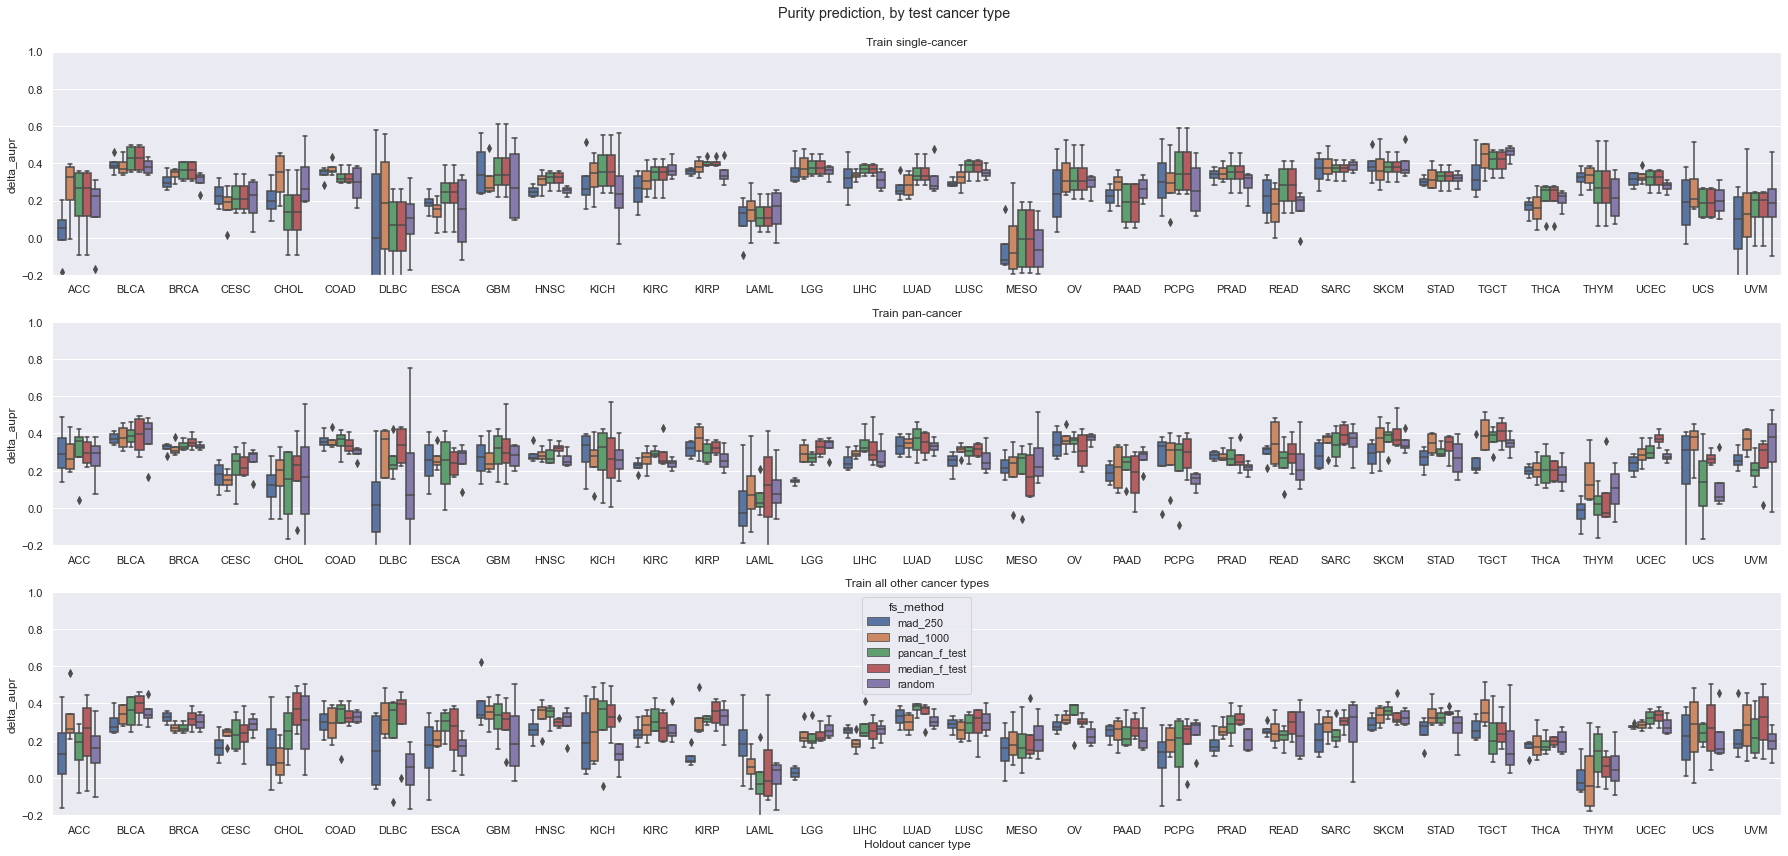

In [13]:
sns.set({'figure.figsize': (25, 12)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 1)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

# split individual cancer types
for ix, to_plot_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    plot_df = (
        to_plot_df.sort_values(by='identifier')
    )
    sns.boxplot(data=plot_df, x='identifier', 
                y=delta_metric, hue='fs_method', 
                hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    if ix == len(dfs_to_plot) - 1:
        ax.set_xlabel('Holdout cancer type')
    else:
        ax.set_xlabel('')
        ax.get_legend().remove()
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, by test cancer type', y=0.99)
plt.tight_layout()

# if output_plots:
#     plt.savefig(output_plots_dir / '{}_by_cancer_type.png'.format(gene),
#                 dpi=200, bbox_inches='tight')

### Plot performance broken down by cancer type and test set

This will show trends for each data partition: i.e. is improved performance for a particular feature selection method driven by a large increase in performance for one or two data partitions and no change for the others, or a small increase in performance across all the data partitions?

In [14]:
sns.set({'figure.figsize': (15, 6)})
sns.set_context('notebook')

plot_fs_methods = [
    'mad_250',
    'pancan_f_test',
    'median_f_test'
]

if cancer_types is None:
    plot_df = (
        pancancer_only_compare_df[
            (pancancer_only_compare_df.identifier == gene) &
            (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
        ].sort_values(by='holdout_cancer_type')
    ).sort_values(by=['seed', 'fold'])
else:
    plot_df = (
        pancancer_only_compare_df[
            (pancancer_only_compare_df.identifier == gene) &
            (pancancer_only_compare_df.holdout_cancer_type.isin(cancer_types)) &
            (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
        ].sort_values(by='holdout_cancer_type')
    ).sort_values(by=['seed', 'fold'])
plot_df['seed/fold'] = plot_df.seed.astype(str) + ', ' + plot_df.fold.astype(str)

g = sns.catplot(
    data=plot_df, x='fs_method', y=delta_metric, col='holdout_cancer_type',
    hue='seed/fold', kind='point', col_wrap=4, order=plot_fs_methods,
    palette='viridis'
)
g.set_titles(col_template='{col_name}')

# if output_plots:
#     plt.savefig(output_plots_dir / '{}_by_cancer_type_lines.png'.format(gene),
#                 dpi=200, bbox_inches='tight')

NameError: name 'cancer_types' is not defined